In [1]:
from gurobipy import *

In [2]:
import json
with open('toy_instance.json') as f:
    json_instance = json.load(f)
    f.close()

In [3]:
json_instance

{'horizon': 5,
 'qualifications': ['A', 'B', 'C'],
 'staff': [{'name': 'Olivia',
   'qualifications': ['A', 'B', 'C'],
   'vacations': []},
  {'name': 'Liam', 'qualifications': ['A', 'B'], 'vacations': [1]},
  {'name': 'Emma', 'qualifications': ['C'], 'vacations': [2]}],
 'jobs': [{'name': 'Job1',
   'gain': 20,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'B': 1, 'C': 1}},
  {'name': 'Job2',
   'gain': 15,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'B': 2}},
  {'name': 'Job3',
   'gain': 15,
   'due_date': 4,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'C': 2}},
  {'name': 'Job4',
   'gain': 20,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'B': 2, 'C': 1}},
  {'name': 'Job5',
   'gain': 10,
   'due_date': 5,
   'daily_penalty': 3,
   'working_days_per_qualification': {'C': 2}}]}

In [4]:
N = len(json_instance['staff'])
M = len(json_instance['jobs'])
K = len(json_instance['qualifications'])
T = int(json_instance['horizon'])

In [5]:
mapping_names = {}
for i in range(len(json_instance['staff'])):
    mapping_names[i] = json_instance['staff'][i]['name']
mapping_names

{0: 'Olivia', 1: 'Liam', 2: 'Emma'}

In [6]:
mapping_qualif = {v:k for (k,v) in enumerate(json_instance['qualifications'])}
mapping_qualif

{'A': 0, 'B': 1, 'C': 2}

In [7]:
import numpy as np
qualifications_mat = np.zeros((N,K))
for i in range(N):
    for qual_k in json_instance['staff'][i]['qualifications']:
        qualifications_mat[i,mapping_qualif[qual_k]]=1
qualifications_mat


array([[1., 1., 1.],
       [1., 1., 0.],
       [0., 0., 1.]])

In [8]:
vacation_mat = np.ones((N,T))
for i in range(N):
    for t in json_instance['staff'][i]['vacations']:
        vacation_mat[i,t-1]=0
vacation_mat

array([[1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.]])

In [9]:
wd_per_qual_mat = np.zeros((M,K))
for j in range(M):
    for qual,wd in json_instance['jobs'][j]['working_days_per_qualification'].items():
        wd_per_qual_mat[j,mapping_qualif[qual]] = wd
wd_per_qual_mat


array([[1., 1., 1.],
       [1., 2., 0.],
       [1., 0., 2.],
       [0., 2., 1.],
       [0., 0., 2.]])

In [10]:
gains_vect = np.zeros((M,))
for j in range(M):
    gains_vect[j] = json_instance['jobs'][j]['gain']
gains_vect

array([20., 15., 15., 20., 10.])

In [11]:
penalties_vect = np.zeros((M,))
for j in range(M):
    penalties_vect[j] = json_instance['jobs'][j]['daily_penalty']
penalties_vect

array([3., 3., 3., 3., 3.])

In [12]:
due_dates_mat = np.zeros((M,T))
for j in range(M):
    for t in range(json_instance['jobs'][j]['due_date']-1,T):
        due_dates_mat[j,t] = 1
due_dates_mat

array([[0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1.]])

In [13]:
def print_plannings(N,M,K,T,mapping_names,vacation_mat,qualifications,x):
    for i in range(N):
        print('planning de {} : '.format(mapping_names[i]))
        for t in range(T):
            print('jour {} : '.format(t+1),end=' ')
            if vacation_mat[i,t]==0:
                        print('jour de congé')
            for j in range(M):
                for k in range(K):
                    if x[i,j,k,t].X == 1 :
                        print('projet {}, compétence {}'.format(j+1,qualifications[k]))

In [14]:
# Instanciation du modèle
m = Model("PL modelling CompuOpti")

# Vecteur de variables
x = m.addVars(N,M,K,T,name="x", vtype=GRB.BINARY)
r = m.addVars(M,T, name="r", vtype=GRB.BINARY)
s = m.addVars(N,M, name="s", vtype=GRB.BINARY)
b = m.addVars(M,T, name="b", vtype=GRB.BINARY)
y = m.addVar(name="y",vtype=GRB.INTEGER)
z = m.addVar(name="z",vtype=GRB.INTEGER)

m.update()

m.addConstrs((x[i,j,k,t] <= qualifications_mat[i,k] for i in range(N) for j in range(M) for k in range(K) for t in range(T)), name = "qualification du personnel")
m.addConstrs((quicksum([x[i,j,k,t] for j in range(M) for k in range(K)]) <= 1 for i in range(N) for t in range(T)),name="unicité de l'affectation quotidienne du personnel")
m.addConstrs((x[i,j,k,t] <= vacation_mat[i,t] for i in range(N) for j in range(M) for k in range(K) for t in range(T)), name = "congés")
m.addConstrs(( quicksum([x[i,j,k,tau] for i in range(N) for tau in range(t+1)]) >= r[j,t] * wd_per_qual_mat[j,k] for j in range(M) for k in range(K) for t in range(T)),name="couverture des qualifications")
m.addConstrs(( quicksum([x[i,j,k,tau] for i in range(N) for tau in range(t+1)]) <= wd_per_qual_mat[j,k] for j in range(M) for k in range(K) for t in range(T)),name="unicité de la réalisation d'un projet")
m.addConstrs((K*T*s[i,j] >= quicksum([x[i,j,k,t] for k in range(K) for t in range(T)]) for i in range(N) for j in range(M) ), name = "affectation à un projet ssi affection à une compétence de ce projet au moins un jour")
m.addConstrs((N*K*b[j,t] >= quicksum([x[i,j,k,t] for i in range(N) for k in range(K)]) for j in range(M) for t in range(T)), name = "contrainte interne sur le début des projets")
m.addConstrs((b[j,t] >= r[j,t] for j in range(M) for t in range(T)),name="début d'un projet avant sa fin")
m.addConstrs((y >= quicksum([s[i,j] for j in range(M)]) for i in range(N)),name="linéarisation de l'objectif 2")
m.addConstrs((z >= quicksum([b[j,t] - r[j,t] for t in range(T)]) for j in range(M)), name = "linéarisation de l'objectif 3")
m.addConstrs((r[j,t+1] >= r[j,t] for j in range(M) for t in range(T-1)),name="contrainte interne à la variable r")
m.addConstrs((b[j,t+1] >= b[j,t] for j in range(M) for t in range(T-1)),name="contrainte interne à la variable b")

obj1 = -quicksum([r[j,T-1]*(gains_vect[j]-quicksum([penalties_vect[j]*(1-r[j,t])*due_dates_mat[j,t] for t in range(T)])) for j in range(M)])
obj2 = y
obj3 = z
m.setObjective(obj1, GRB.MINIMIZE)

# Paramétrage (mode mute)
m.params.outputflag = 0

# Résolution du PL
m.optimize()

# Affichage en mode texte du PL
print(m.display())

print("La valeur optimale de l'objectif 1 est {}".format(int(m.objVal)))
print("Les valeurs des objectifs 1 et 2 sont alors {} et {}".format(int(obj2.x),int(obj3.x)))
obj1_opti = int(m.objVal)

print_plannings(N,M,K,T,mapping_names,vacation_mat,json_instance['qualifications'],x)
                

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-11
None
La valeur optimale de l'objectif 1 est -65
Les valeurs des objectifs 1 et 2 sont alors 5 et 5
planning de Olivia : 
jour 1 :  projet 1, compétence A
jour 2 :  projet 2, compétence B
jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence C
jour 5 :  projet 5, compétence C
planning de Liam : 
jour 1 :  jour de congé
jour 2 :  projet 1, compétence B
jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence A
jour 5 :  projet 2, compétence B
planning de Emma : 
jour 1 :  projet 4, compétence C
jour 2 :  jour de congé
jour 3 :  projet 1, compétence C
jour 4 :  projet 3, compétence C
jour 5 :  projet 5, compétence C


In [15]:
# Instanciation du modèle
m2 = Model("PL modelling CompuOpti")

# Vecteur de variables
x = m2.addVars(N,M,K,T,name="x", vtype=GRB.BINARY)
r = m2.addVars(M,T, name="r", vtype=GRB.BINARY)
s = m2.addVars(N,M, name="s", vtype=GRB.BINARY)
b = m2.addVars(M,T, name="b", vtype=GRB.BINARY)
y = m2.addVar(name="y",vtype=GRB.INTEGER)
z = m2.addVar(name="z",vtype=GRB.INTEGER)

m2.update()

m2.addConstrs((x[i,j,k,t] <= qualifications_mat[i,k] for i in range(N) for j in range(M) for k in range(K) for t in range(T)), name = "qualification du personnel")
m2.addConstrs((quicksum([x[i,j,k,t] for j in range(M) for k in range(K)]) <= 1 for i in range(N) for t in range(T)),name="unicité de l'affectation quotidienne du personnel")
m2.addConstrs((x[i,j,k,t] <= vacation_mat[i,t] for i in range(N) for j in range(M) for k in range(K) for t in range(T)), name = "congés")
m2.addConstrs(( quicksum([x[i,j,k,tau] for i in range(N) for tau in range(t+1)]) >= r[j,t] * wd_per_qual_mat[j,k] for j in range(M) for k in range(K) for t in range(T)),name="couverture des qualifications")
m2.addConstrs(( quicksum([x[i,j,k,tau] for i in range(N) for tau in range(t+1)]) <= wd_per_qual_mat[j,k] for j in range(M) for k in range(K) for t in range(T)),name="unicité de la réalisation d'un projet")
m2.addConstrs((K*T*s[i,j] >= quicksum([x[i,j,k,t] for k in range(K) for t in range(T)]) for i in range(N) for j in range(M) ), name = "affectation à un projet ssi affection à une compétence de ce projet au moins un jour")
m2.addConstrs((N*K*b[j,t] >= quicksum([x[i,j,k,t] for i in range(N) for k in range(K)]) for j in range(M) for t in range(T)), name = "contrainte interne sur le début des projets")
m2.addConstrs((b[j,t] >= r[j,t] for j in range(M) for t in range(T)),name="début d'un projet avant sa fin")
m2.addConstrs((y >= quicksum([s[i,j] for j in range(M)]) for i in range(N)),name="linéarisation de l'objectif 2")
m2.addConstrs((z >= quicksum([b[j,t] - r[j,t] for t in range(T)]) for j in range(M)), name = "linéarisation de l'objectif 3")
m2.addConstrs((r[j,t+1] >= r[j,t] for j in range(M) for t in range(T-1)),name="contrainte interne à la variable r")
m2.addConstrs((b[j,t+1] >= b[j,t] for j in range(M) for t in range(T-1)),name="contrainte interne à la variable b")

obj1 = - quicksum([r[j,T-1]*(gains_vect[j]-quicksum([penalties_vect[j]*(1-r[j,t])*due_dates_mat[j,t] for t in range(T)])) for j in range(M)])
obj2 = y
obj3 = z
m2.setObjective(obj2, GRB.MINIMIZE)

# Paramétrage (mode mute)
m2.params.outputflag = 0

# Résolution du PL
m2.optimize()

# Affichage en mode texte du PL
print(m2.display())

print("La valeur optimale de l'objectif 2 est {}".format(int(m2.objVal)))
print("Les valeurs des objectifs 1 et 3 sont alors {} et {}".format(int(obj1.getValue()),int(obj3.x)))
obj2_opti = int(m2.objVal)

print_plannings(N,M,K,T,mapping_names,vacation_mat,json_instance['qualifications'],x)


None
La valeur optimale de l'objectif 2 est 0
Les valeurs des objectifs 1 et 3 sont alors 0 et 0
planning de Olivia : 
jour 1 :  jour 2 :  jour 3 :  jour 4 :  jour 5 :  planning de Liam : 
jour 1 :  jour de congé
jour 2 :  jour 3 :  jour 4 :  jour 5 :  planning de Emma : 
jour 1 :  jour 2 :  jour de congé
jour 3 :  jour 4 :  jour 5 :  

In [16]:
# Instanciation du modèle
m3 = Model("PL modelling CompuOpti")

# Vecteur de variables
x = m3.addVars(N,M,K,T,name="x", vtype=GRB.BINARY)
r = m3.addVars(M,T, name="r", vtype=GRB.BINARY)
s = m3.addVars(N,M, name="s", vtype=GRB.BINARY)
b = m3.addVars(M,T, name="b", vtype=GRB.BINARY)
y = m3.addVar(name="y",vtype=GRB.INTEGER)
z = m3.addVar(name="z",vtype=GRB.INTEGER)

m3.update()

m3.addConstrs((x[i,j,k,t] <= qualifications_mat[i,k] for i in range(N) for j in range(M) for k in range(K) for t in range(T)), name = "qualification du personnel")
m3.addConstrs((quicksum([x[i,j,k,t] for j in range(M) for k in range(K)]) <= 1 for i in range(N) for t in range(T)),name="unicité de l'affectation quotidienne du personnel")
m3.addConstrs((x[i,j,k,t] <= vacation_mat[i,t] for i in range(N) for j in range(M) for k in range(K) for t in range(T)), name = "congés")
m3.addConstrs(( quicksum([x[i,j,k,tau] for i in range(N) for tau in range(t+1)]) >= r[j,t] * wd_per_qual_mat[j,k] for j in range(M) for k in range(K) for t in range(T)),name="couverture des qualifications")
m3.addConstrs(( quicksum([x[i,j,k,tau] for i in range(N) for tau in range(t+1)]) <= wd_per_qual_mat[j,k] for j in range(M) for k in range(K) for t in range(T)),name="unicité de la réalisation d'un projet")
m3.addConstrs((K*T*s[i,j] >= quicksum([x[i,j,k,t] for k in range(K) for t in range(T)]) for i in range(N) for j in range(M) ), name = "affectation à un projet ssi affection à une compétence de ce projet au moins un jour")
m3.addConstrs((N*K*b[j,t] >= quicksum([x[i,j,k,t] for i in range(N) for k in range(K)]) for j in range(M) for t in range(T)), name = "contrainte interne sur le début des projets")
m3.addConstrs((b[j,t] >= r[j,t] for j in range(M) for t in range(T)),name="début d'un projet avant sa fin")
m3.addConstrs((y >= quicksum([s[i,j] for j in range(M)]) for i in range(N)),name="linéarisation de l'objectif 2")
m3.addConstrs((z >= quicksum([b[j,t] - r[j,t] for t in range(T)]) for j in range(M)), name = "linéarisation de l'objectif 3")
m3.addConstrs((r[j,t+1] >= r[j,t] for j in range(M) for t in range(T-1)),name="contrainte interne à la variable r")
m3.addConstrs((b[j,t+1] >= b[j,t] for j in range(M) for t in range(T-1)),name="contrainte interne à la variable b")

obj1 = - quicksum([r[j,T-1]*(gains_vect[j]-quicksum([penalties_vect[j]*(1-r[j,t])*due_dates_mat[j,t] for t in range(T)])) for j in range(M)])
obj2 = y
obj3 = z

m3.addConstr(obj1 <= -59)
m3.setObjective(obj3,GRB.MINIMIZE)

# Paramétrage (mode mute)
m3.params.outputflag = 0

# Résolution du PL
m3.optimize()

# Affichage en mode texte du PL
print(m3.display())

print("La valeur optimale de l'objectif 3 est {}".format(int(m3.objVal)))
print("Les valeurs des objectifs 1 et 2 sont alors {} et {}".format(int(obj1.getValue()),int(obj2.x)))
obj3_opti = int(m3.objVal)

print_plannings(N,M,K,T,mapping_names,vacation_mat,json_instance['qualifications'],x)

None
La valeur optimale de l'objectif 3 est 0
Les valeurs des objectifs 1 et 2 sont alors -59 et 5
planning de Olivia : 
jour 1 :  projet 5, compétence C
jour 2 :  jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence C
jour 5 :  projet 1, compétence A
planning de Liam : 
jour 1 :  jour de congé
jour 2 :  jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence A
jour 5 :  projet 1, compétence B
planning de Emma : 
jour 1 :  projet 5, compétence C
jour 2 :  jour de congé
jour 3 :  projet 4, compétence C
jour 4 :  projet 3, compétence C
jour 5 :  projet 1, compétence C


In [17]:
optimal_sol = obj1_opti, obj2_opti, obj3_opti
optimal_sol

(-65, 0, 0)

In [18]:
nadir_sol = (0,M,T)
nadir_sol

(0, 5, 5)

In [65]:
def solve_epsilon_constraint_prog(epsilon,verbose=False):
    # Instanciation du modèle
    m = Model("PL espilon constraint")

    # Vecteur de variables
    x = m.addVars(N,M,K,T,name="x", vtype=GRB.BINARY)
    r = m.addVars(M,T, name="r", vtype=GRB.BINARY)
    s = m.addVars(N,M, name="s", vtype=GRB.BINARY)
    b = m.addVars(M,T, name="b", vtype=GRB.BINARY)
    y = m.addVar(name="y",vtype=GRB.INTEGER)
    z = m.addVar(name="z",vtype=GRB.INTEGER)

    m.update()

    m.addConstrs((x[i,j,k,t] <= qualifications_mat[i,k] for i in range(N) for j in range(M) for k in range(K) for t in range(T)), name = "qualification du personnel")
    m.addConstrs((quicksum([x[i,j,k,t] for j in range(M) for k in range(K)]) <= 1 for i in range(N) for t in range(T)),name="unicité de l'affectation quotidienne du personnel")
    m.addConstrs((x[i,j,k,t] <= vacation_mat[i,t] for i in range(N) for j in range(M) for k in range(K) for t in range(T)), name = "congés")
    m.addConstrs(( quicksum([x[i,j,k,tau] for i in range(N) for tau in range(t+1)]) >= r[j,t] * wd_per_qual_mat[j,k] for j in range(M) for k in range(K) for t in range(T)),name="couverture des qualifications")
    m.addConstrs(( quicksum([x[i,j,k,tau] for i in range(N) for tau in range(t+1)]) <= wd_per_qual_mat[j,k] for j in range(M) for k in range(K) for t in range(T)),name="unicité de la réalisation d'un projet")
    m.addConstrs((K*T*s[i,j] >= quicksum([x[i,j,k,t] for k in range(K) for t in range(T)]) for i in range(N) for j in range(M) ), name = "affectation à un projet ssi affection à une compétence de ce projet au moins un jour")
    m.addConstrs((N*K*b[j,t] >= quicksum([x[i,j,k,t] for i in range(N) for k in range(K)]) for j in range(M) for t in range(T)), name = "contrainte interne sur le début des projets")
    m.addConstrs((b[j,t] >= r[j,t] for j in range(M) for t in range(T)),name="début d'un projet avant sa fin")
    m.addConstrs((y >= quicksum([s[i,j] for j in range(M)]) for i in range(N)),name="linéarisation de l'objectif 2")
    m.addConstrs((z >= quicksum([b[j,t] - r[j,t] for t in range(T)]) for j in range(M)), name = "linéarisation de l'objectif 3")
    m.addConstrs((r[j,t+1] >= r[j,t] for j in range(M) for t in range(T-1)),name="contrainte interne à la variable r")
    m.addConstrs((b[j,t+1] >= b[j,t] for j in range(M) for t in range(T-1)),name="contrainte interne à la variable b")

    obj1 = -quicksum([r[j,T-1]*(gains_vect[j]-quicksum([penalties_vect[j]*(1-r[j,t])*due_dates_mat[j,t] for t in range(T)])) for j in range(M)])
    obj2 = y
    obj3 = z
    objs = [obj1,obj2,obj3]
    m.addConstr(obj2 <= epsilon[1] , name = 'espilon constraint obj 2')
    m.addConstr(obj3 <= epsilon[2] , name = 'espilon constraint obj 3')
    m.setObjective(obj1, GRB.MINIMIZE)

    # Paramétrage (mode mute)
    m.params.outputflag = 0

    # Résolution du PL
    m.optimize()
    
    if m.status == GRB.INFEASIBLE:
        raise Exception('no solution')
    
    if verbose:
        print('planning for eps2 = {} and eps3 = {}'.format(epsilon[1],epsilon[2]))
        print_plannings(N,M,K,T,mapping_names,vacation_mat,json_instance['qualifications'],x)
        print('==================================')
    
    return [m.objVal, obj2.x, obj3.x]



In [57]:
def epsilon_constraint():
    pareto_surface = []
    epsilon_constraints = []
    epsilon = np.array(nadir_sol)
    sol_2 = np.inf
    feasible=True
    while sol_2 > optimal_sol[1] and feasible :
        sol_3 = np.inf
        while sol_3 > optimal_sol[2] and feasible:
            print('step with eps2 = {} and eps3 = {}'.format(epsilon[1],epsilon[2]))
            try:
                solution = solve_epsilon_constraint_prog(epsilon)
            except:
                feasible = False
                break
            pareto_surface.append(solution)
            epsilon_constraints.append(epsilon.copy())
            print('solution found : ', solution)
            sol_2,sol_3 = solution[1],solution[2]
            epsilon[2] = sol_3 - 1
        epsilon[1] -= 1
        epsilon[2] = nadir_sol[2]
        if not(feasible):
            try :
                solve_epsilon_constraint_prog(epsilon)
                feasible = True
            except :
                break
    return pareto_surface,epsilon_constraints

In [59]:
pareto_surface_non_filtered, epsilon_constraints = epsilon_constraint()
pareto_surface_non_filtered = np.array(pareto_surface_non_filtered)
epsilon_constraints = np.array(epsilon_constraints)

step with eps2 = 5 and eps3 = 5
solution found :  [-65.0, 5.0, 5.0]
step with eps2 = 5 and eps3 = 4
solution found :  [-65.0, 5.0, 4.0]
step with eps2 = 5 and eps3 = 3
solution found :  [-65.0, 5.0, 3.0]
step with eps2 = 5 and eps3 = 2
solution found :  [-65.0, 5.0, 2.0]
step with eps2 = 5 and eps3 = 1
solution found :  [-65.0, 5.0, 1.0]
step with eps2 = 5 and eps3 = 0
solution found :  [-59.0, 5.0, 0.0]
step with eps2 = 4 and eps3 = 5
solution found :  [-65.0, 4.0, 5.0]
step with eps2 = 4 and eps3 = 4
solution found :  [-65.0, 4.0, 4.0]
step with eps2 = 4 and eps3 = 3
solution found :  [-65.0, 4.0, 3.0]
step with eps2 = 4 and eps3 = 2
solution found :  [-65.0, 4.0, 2.0]
step with eps2 = 4 and eps3 = 1
solution found :  [-65.0, 4.0, 1.0]
step with eps2 = 4 and eps3 = 0
solution found :  [-59.0, 4.0, 0.0]
step with eps2 = 3 and eps3 = 5
solution found :  [-65.0, 3.0, 5.0]
step with eps2 = 3 and eps3 = 4
solution found :  [-65.0, 3.0, 4.0]
step with eps2 = 3 and eps3 = 3
solution found :

In [60]:
def is_pareto_efficient(pareto_front):
    is_efficient = np.ones(pareto_front.shape[0], dtype = bool)
    for i, c in enumerate(pareto_front):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(pareto_front[is_efficient]<c, axis=1)  
            is_efficient[i] = True  
    return is_efficient
    
mask = is_pareto_efficient(pareto_surface_non_filtered)
pareto_surface = pareto_surface_non_filtered[mask]
epsilon_cstr = epsilon_constraints[mask]

In [61]:
pareto_surface

array([[-59.,   4.,   0.],
       [-65.,   3.,   1.],
       [-49.,   3.,   0.],
       [-65.,   2.,   2.],
       [-55.,   2.,   1.],
       [-37.,   2.,   0.],
       [-42.,   1.,   2.],
       [-30.,   1.,   1.],
       [-20.,   1.,   0.],
       [  0.,   0.,   0.]])

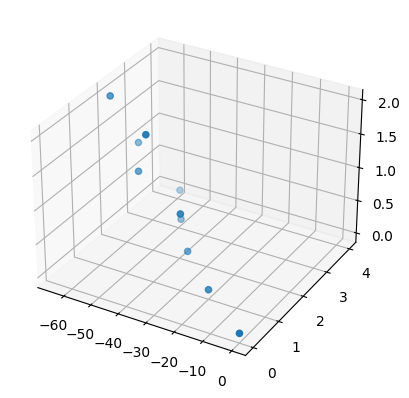

In [62]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

x_data = [t[0] for t in pareto_surface]
y_data = [t[1] for t in pareto_surface]
z_data = [t[2] for t in pareto_surface]
ax.scatter3D(x_data,y_data,z_data)

In [67]:
for eps in epsilon_cstr :
    solve_epsilon_constraint_prog(eps, verbose=True)

planning for eps2 = 4 and eps3 = 0
planning de Olivia : 
jour 1 :  projet 5, compétence C
jour 2 :  jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence C
jour 5 :  projet 1, compétence B
planning de Liam : 
jour 1 :  jour de congé
jour 2 :  jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence A
jour 5 :  projet 1, compétence A
planning de Emma : 
jour 1 :  projet 5, compétence C
jour 2 :  jour de congé
jour 3 :  projet 4, compétence C
jour 4 :  projet 3, compétence C
jour 5 :  projet 1, compétence C
planning for eps2 = 3 and eps3 = 1
planning de Olivia : 
jour 1 :  projet 1, compétence A
jour 2 :  projet 1, compétence B
jour 3 :  projet 3, compétence C
jour 4 :  projet 3, compétence C
jour 5 :  projet 5, compétence C
planning de Liam : 
jour 1 :  jour de congé
jour 2 :  projet 4, compétence B
jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence A
jour 5 :  projet 2, compétence B
planning de Emma : 
jour 1 :  projet 1, compétence C
jour 2 :  jour de con